In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from collections import OrderedDict
from hyperopt import fmin, tpe, hp, Trials, space_eval, plotting
from tflite2xcore.model_generation import utils
import tensorflow as tf
from sklearn.externals import joblib
utils.set_all_seeds(42)

In [2]:
SEARCH_SPACE = OrderedDict([('learning_rate',
                             hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))),
                            ('epochs',
                             hp.choice('epochs', range(1, 51, 1))),
                            ('batch_size',
                             hp.choice('batch_size', [32, 64, 128, 256, 512])),
                            ('dropout',
                            hp.choice('dropout', np.arange(0.1, 0.31, 0.01))),
                            ('l1_reg',
                             hp.choice('l1_reg', np.arange(1e-5, 2e-4, 1e-6)))
                           ])
STATIC_PARAMS = {'boosting': 'gbdt',
                'objective':'binary',
                'metric': 'auc',
                'num_threads': 12,
                }
# Data
data = utils.prepare_MNIST(False, simard=False, padding=2)

for k, v in data.items():
    print(f"Prepped data[{k}] with shape: {v.shape}")

Prepped data[x_train] with shape: (4096, 32, 32, 1)
Prepped data[x_test] with shape: (1024, 32, 32, 1)
Prepped data[x_val] with shape: (100, 32, 32, 1)
Prepped data[y_train] with shape: (4096,)
Prepped data[y_test] with shape: (1024,)
Prepped data[y_val] with shape: (100,)


In [3]:
def train_evaluate(params):
    core_model = tf.keras.Sequential(
        name='hyperopt_test',
        layers=[
            tf.keras.layers.Flatten(input_shape=(32, 32, 1), name='input'),
            tf.keras.layers.Dense(390, activation='tanh', name='dense_1',
                                  kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg'])),
            tf.keras.layers.Dropout(params['dropout']),
            tf.keras.layers.Dense(290, activation='tanh', name='dense_2',
                                 kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg'])),
            tf.keras.layers.Dropout(params['dropout']),
            tf.keras.layers.Dense(10, activation='softmax', name='output',
                                 kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg']))
    ])
    core_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate']),
        metrics=['accuracy'])
    core_model.fit(
        data['x_train'], data['y_train'],
        validation_data=(data['x_test'], data['y_test']),
        batch_size=params['batch_size'],
        verbose=0,
        epochs=params['epochs']
    )
    _, accuracy = core_model.evaluate(data['x_test'], data['y_test'])
    return accuracy

def objective(params):
    all_params = {**params, **STATIC_PARAMS}
    return -1.0 * train_evaluate(all_params)

In [4]:
trials = Trials()
HPO_PARAMS = {'max_evals': 1000,
              'trials': trials
             }
best = fmin(
    fn=objective,
    space=SEARCH_SPACE,
    algo=tpe.rand.suggest,
    **HPO_PARAMS
)

  32/1024 [..............................]              
 - ETA: 1s - loss: 33.9429 - accuracy: 0.5625           
                                                        
1024/1024 [==============================]              
 - 0s 78us/sample - loss: 35.0190 - accuracy: 0.5195    

  32/1024 [..............................]                                 
 - ETA: 1s - loss: 8.2679 - accuracy: 0.8125                               
                                                                          
1024/1024 [==============================]                                 
 - 0s 83us/sample - loss: 10.2923 - accuracy: 0.7402                       

  32/1024 [..............................]                                  
 - ETA: 0s - loss: 4.6713 - accuracy: 0.7188                                
                                                                           
1024/1024 [==============================]                                  
 - 0s 27us/sample - loss: 4

In [5]:
print(f"Found minimum after {HPO_PARAMS['max_evals']} trials:")
print(best)
print("")
print(space_eval(SEARCH_SPACE, best))

Found minimum after 1000 trials:
{'batch_size': 3, 'dropout': 13, 'epochs': 47, 'l1_reg': 28, 'learning_rate': 0.01529202882387714}

{'batch_size': 256, 'dropout': 0.22999999999999995, 'epochs': 48, 'l1_reg': 3.8000000000000016e-05, 'learning_rate': 0.01529202882387714}


In [6]:
best_params = space_eval(SEARCH_SPACE, best)
objective(best_params)

1024/1024 [==============================] - 0s 78us/sample - loss: 1.3017 - accuracy: 0.9414


-0.94140625

1024/1024 [==============================] - 0s 79us/sample - loss: 1.2819 - accuracy: 0.9375
Acc range: (0.939453125, 0.873046875)
Acc median: 0.919921875
avg best error: -0.9375


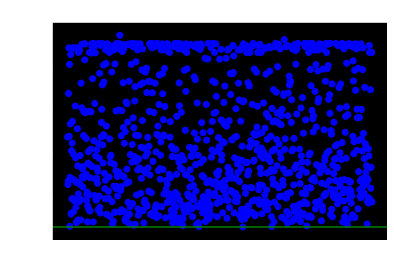

Showing Histogram of 1000 jobs


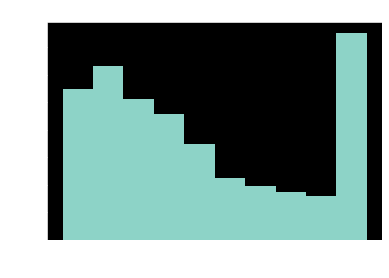

In [7]:
l = [-objective(best_params) for e in range(50)]
maxv = np.max(l)
minv = np.min(l)
print(f"Acc range: ({maxv}, {minv})\nAcc median: {np.median(l)}")

In [ ]:
joblib.dump(trials, './tune_mlp_trials.pkl')

In [10]:
trials = joblib.load('./tune_mlp_trials.pkl')

In [ ]:
from hyperopt import plotting
plotting.main_plot_history(trials)
plotting.main_plot_histogram(trials)